In [1]:
import os
import sys
import numpy as np
import stopit
import time
import matplotlib.pyplot as plt

In [2]:
# importing neurokit2 as a submodule so that it's always the same version
repo_name = "fixpeaks_with_large_gaps"
submodule_parent_dir = "lib"
submodule_name = "NeuroKitMod"

repo_path = os.getcwd()
base_dir = os.path.basename(repo_path)
while base_dir != repo_name:
    repo_path = os.path.dirname(os.path.abspath(repo_path))
    base_dir = os.path.basename(repo_path)
    
submodule_path = os.path.join(repo_path, submodule_parent_dir, submodule_name)
sys.path.insert(0, submodule_path)

In [3]:
import neurokit2 as nk

In [4]:
# load biosignal data
data = nk.data(dataset="bio_resting_8min_100hz")
# get ECG channel
ecg_data_all = data["ECG"]
# sampling rate in file name
sampling_rate = 100
# take 5 minutes of the recording
num_seconds = 300

# set the seed for the random number generator
# used for distorting the ECG data
seed = 42
np.random.seed(seed)

# select a 5 minute segment
first_sample = np.random.randint(0, len(ecg_data_all) - num_seconds * sampling_rate)
last_sample = first_sample + num_seconds * sampling_rate
ecg_clean = np.array(ecg_data_all[first_sample : last_sample])

# distort the ECG data
noise_shape = "laplace"
noise_amplitude = 0.5
noise_frequency = 5
powerline_amplitude = 0
powerline_frequency = 50
artifacts_amplitude = 2
artifacts_number = int(np.floor((len(ecg_clean) / sampling_rate) / 2))
artifacts_frequency = 10
linear_drift = False

# create a copy of ECG data
ecg_noise = ecg_clean.copy()
ecg_noise = nk.signal_distort(
    ecg_noise,
    sampling_rate=sampling_rate,
    noise_shape=noise_shape,
    noise_amplitude=noise_amplitude,
    noise_frequency=noise_frequency,
    powerline_amplitude=powerline_amplitude,
    powerline_frequency=powerline_frequency,
    artifacts_amplitude=artifacts_amplitude,
    artifacts_frequency=artifacts_frequency,
    artifacts_number=artifacts_number,
    linear_drift=linear_drift,
    random_state=seed,
    silent=False
)
signals_clean, info_clean = nk.ecg_process(ecg_clean, sampling_rate=sampling_rate)
signals_noise, info_noise = nk.ecg_process(ecg_noise, sampling_rate=sampling_rate)

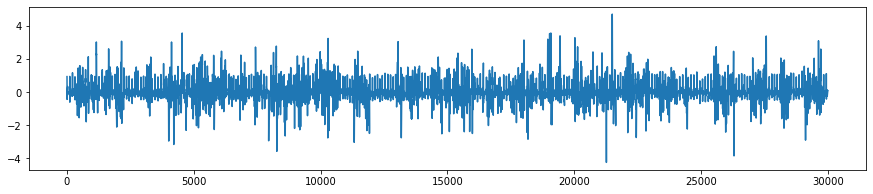

In [5]:
plt.figure(figsize=(15,3))
plt.plot(signals_noise["ECG_Raw"])
plt.show()

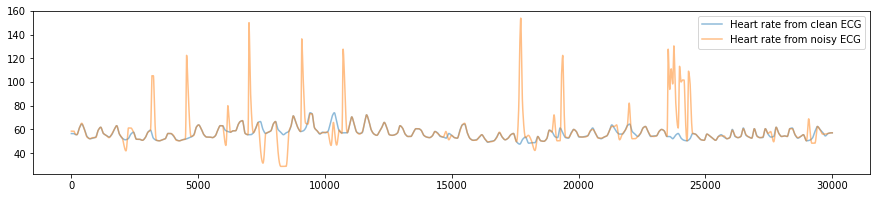

In [6]:
plt.figure(figsize=(15,3))
plt.plot(signals_clean["ECG_Rate"], alpha=0.5)
plt.plot(signals_noise["ECG_Rate"], alpha=0.5)
plt.legend(["Heart rate from clean ECG", "Heart rate from noisy ECG"])
plt.show()


In [7]:
# Format input
from neurokit2.signal.signal_formatpeaks import _signal_formatpeaks_sanitize
peaks = _signal_formatpeaks_sanitize(signals_noise)
peaks_copy = peaks.copy()

In [8]:
interval = nk.signal_period(peaks, sampling_rate=sampling_rate)
interval_without_outliers = interval[np.invert(nk.find_outliers(interval))]

In [9]:
interval_min = np.min(interval_without_outliers)
interval_max = np.max(interval_without_outliers)

In [10]:
print(interval_min)

0.64


In [11]:
method = "Kubios"
_, peaks_corrected = nk.signal_fixpeaks(peaks=peaks, method=method, sampling_rate=sampling_rate)

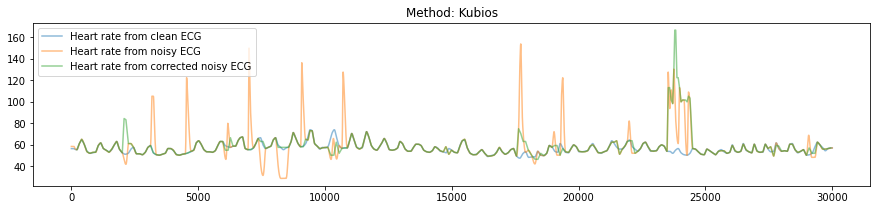

In [12]:
plt.figure(figsize=(15,3))
plt.plot(signals_clean["ECG_Rate"], alpha=0.5)
plt.plot(signals_noise["ECG_Rate"], alpha=0.5)
plt.plot(peaks_corrected[1:], 60/np.diff(peaks_corrected/sampling_rate), alpha=0.5)
plt.legend(["Heart rate from clean ECG", "Heart rate from noisy ECG", "Heart rate from corrected noisy ECG"])
plt.title("Method: " + method)
plt.show()

In [13]:
method = "neurokit"
max_seconds = 10
with stopit.ThreadingTimeout(max_seconds) as context_manager:
    peaks_corrected_nk = nk.signal_fixpeaks(peaks=peaks, method=method, interval_min=interval_min, interval_max=interval_max, iteration_max=1, sampling_rate=sampling_rate, interpolate_on_peaks=True)
if context_manager.state == context_manager.TIMED_OUT:
    print("Took more than " + str(max_seconds) + " seconds. TIMED_OUT")

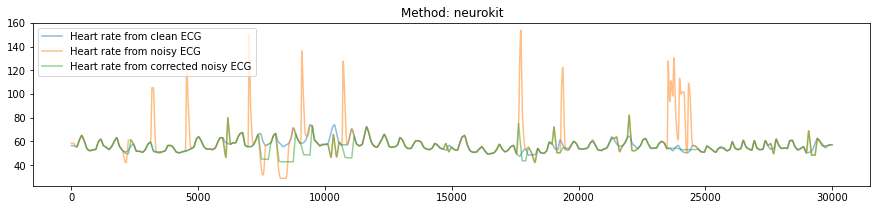

In [14]:
try:
    peaks_corrected = peaks_corrected_nk
    plt.figure(figsize=(15,3))
    plt.plot(signals_clean["ECG_Rate"], alpha=0.5)
    plt.plot(signals_noise["ECG_Rate"], alpha=0.5)
    plt.plot(peaks_corrected[1:], 60/np.diff(peaks_corrected/sampling_rate), alpha=0.5)
    plt.legend(["Heart rate from clean ECG", "Heart rate from noisy ECG", "Heart rate from corrected noisy ECG"])
    plt.title("Method: " + method)
    plt.show()
except:
    pass